In [83]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
from geopy import distance
import copy
import folium
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set(rc={'figure.figsize':(11.7,8.27)})

# Data Preperation

## Retrieve and Wrangling Data
1. Retrieving the data from multiple CSV Files
2. Standardize the columns across all 3 files (Changing Month to Year to calculate the remaining_lease easily)
3. Combining all the tables into 1 DataFrame, then check if there are null values to ensure data integrity

In [84]:
# Raw data comes in multiple files.
df_12_14 = pd.read_csv('resale-flat-prices/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
df_14_16 = pd.read_csv('resale-flat-prices/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
df_17 = pd.read_csv('resale-flat-prices/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [85]:
#df_12_14 does not have remaining_lease. Remaining lease = 99- (year-lease_commence_date)
df_12_14['month'] = df_12_14['month'].str.slice(0,4).astype(int)
df_12_14.rename(columns={'month':'year'},inplace=True)
df_12_14['remaining_lease'] = 99 - (df_12_14['year'] - df_12_14['lease_commence_date'])

fixed_columns = list(df_12_14.columns[:-2]) + list([df_12_14.columns[-1]]) + list([df_12_14.columns[-2]])
df_12_14 = df_12_14[fixed_columns]

#converting df_14_16 remaining_lease to int
df_14_16['month'] = df_14_16['month'].str.slice(0,4).astype(int)
df_14_16.rename(columns={'month':'year'},inplace=True)

#converting df_17 remaining_lease to int
df_17['remaining_lease'] = df_17['remaining_lease'].str.slice(0,2).astype(int)
df_17['month'] = df_17['month'].str.slice(0,4).astype(int)
df_17.rename(columns={'month':'year'},inplace=True)

In [86]:
# Combining the dataframes into one
df_combined = pd.concat([df_12_14, df_14_16, df_17], ignore_index=True)


# Checking for NaN or NA values
print(df_combined.isnull().values.any())

False


In [87]:
# df_combined has an errornous address "St George Road" which has to be changed to SAINT GEORGE'S ROAD
for index in df_combined.index:
    street_name = df_combined.loc[index, 'street_name']
    if 'ST. GEORGE\'S' in street_name:
        df_combined.loc[index, 'street_name'] = street_name.replace('ST.', 'SAINT')

## Streamlining the combined data to include only relevant data
1. Insert Full Addresses (Block Number + Street_name) to allow for more precise analysis of distances
2. Dropping columns that are non-essential to this study

In [88]:
#Inserting Address Columns for more precise analysis
df_combined['Address'] = df_combined['block'] + ' ' + df_combined['street_name']
df_combined

#Dropping non-essential columns
df_combined.drop(['flat_model', 'lease_commence_date', 'block', 'street_name'], axis=1, inplace=True)
df_combined

,year,town,flat_type,storey_range,floor_area_sqm,remaining_lease,resale_price,Address
0,2012,ANG MO KIO,2 ROOM,06 TO 10,45.0,73,250000.0,172 ANG MO KIO AVE 4
1,2012,ANG MO KIO,2 ROOM,01 TO 05,44.0,67,265000.0,510 ANG MO KIO AVE 8
2,2012,ANG MO KIO,3 ROOM,06 TO 10,68.0,67,315000.0,610 ANG MO KIO AVE 4
3,2012,ANG MO KIO,3 ROOM,01 TO 05,67.0,71,320000.0,474 ANG MO KIO AVE 10
4,2012,ANG MO KIO,3 ROOM,06 TO 10,67.0,67,321000.0,604 ANG MO KIO AVE 5
...,...,...,...,...,...,...,...,...
157512,2020,YISHUN,EXECUTIVE,01 TO 03,146.0,67,620000.0,355 YISHUN RING RD
157513,2020,YISHUN,EXECUTIVE,10 TO 12,147.0,66,570000.0,792 YISHUN RING RD
157514,2020,YISHUN,EXECUTIVE,01 TO 03,164.0,71,690000.0,618 YISHUN RING RD
157515,2020,YISHUN,EXECUTIVE,01 TO 03,142.0,66,505000.0,611 YISHUN ST 61


# Data Exploration
This section will investigate some prelimenary trends in the raw data, discover if any there is skewnessin the data and it also helps to decide how the study can be conducted

## investigating the prices of different housing types, and deciding which flat_type to investigate

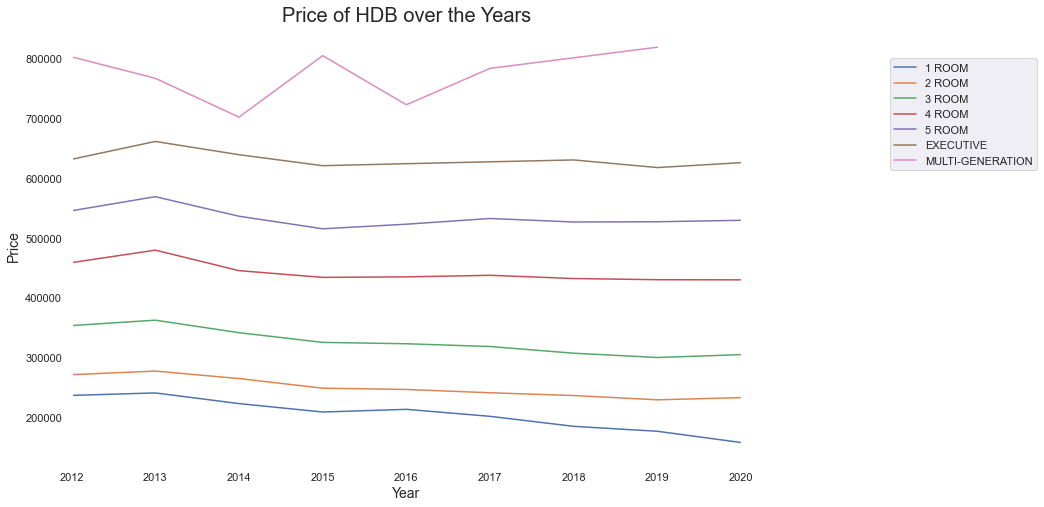

4 ROOM              63641
3 ROOM              41815
5 ROOM              37507
EXECUTIVE           12491
2 ROOM               1920
1 ROOM                 84
MULTI-GENERATION       59
Name: flat_type, dtype: int64

In [89]:
### Plotting the price variations across the different flat types
years = list(range(df_combined.loc[0,'year'], df_combined.loc[len(df_combined)-1, 'year']+1))
result = dict({})

for ftype, df_ftype in df_combined.groupby('flat_type'):
    values = []
    for year, df_byyear in df_ftype.groupby('year'):
        values.append(df_byyear.resale_price.mean())
    result[ftype] = values
    values = []


df = pd.DataFrame.from_dict(result, orient='index')
df = df.transpose() 
df.insert(loc=0, column='Year', value=years)

#Plotting the graph to show prices
figure(figsize=(12, 8))
ax = plt.gca()
df.plot(kind='line',x='Year',y='1 ROOM', ax=ax)
df.plot(kind='line',x='Year',y='2 ROOM',ax=ax)
df.plot(kind='line',x='Year',y='3 ROOM',ax=ax)
df.plot(kind='line',x='Year',y='4 ROOM',ax=ax)
df.plot(kind='line',x='Year',y='5 ROOM',ax=ax)
df.plot(kind='line',x='Year',y='EXECUTIVE',ax=ax)
df.plot(kind='line',x='Year',y='MULTI-GENERATION',ax=ax)

ax.set_facecolor(color='white')
#ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='center right', bbox_to_anchor=(1.45, 0.8), ncol=1)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('Price of HDB over the Years', fontsize=20)
plt.show()

df_combined['flat_type'].value_counts()

### Given that prices tends similarly, we will focus on 4 room flats, since it makes up the largest proportion of flats

In [90]:
df_combined = df_combined[df_combined['flat_type']=='4 ROOM']
df_combined.drop(['flat_type'], axis=1, inplace=True)
df_combined = df_combined.reset_index(drop=True)
df_combined

/Users/bryangwan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,year,town,storey_range,floor_area_sqm,remaining_lease,resale_price,Address
0,2012,ANG MO KIO,01 TO 05,82.0,63,400000.0,218 ANG MO KIO AVE 1
1,2012,ANG MO KIO,01 TO 05,91.0,67,411000.0,601 ANG MO KIO AVE 5
2,2012,ANG MO KIO,06 TO 10,92.0,65,427000.0,108 ANG MO KIO AVE 4
3,2012,ANG MO KIO,06 TO 10,92.0,65,430000.0,105 ANG MO KIO AVE 4
4,2012,ANG MO KIO,06 TO 10,92.0,66,433000.0,438 ANG MO KIO AVE 10
...,...,...,...,...,...,...,...
63636,2020,YISHUN,04 TO 06,84.0,66,308000.0,879 YISHUN ST 81
63637,2020,YISHUN,10 TO 12,104.0,66,373000.0,868 YISHUN ST 81
63638,2020,YISHUN,01 TO 03,105.0,67,367000.0,852 YISHUN ST 81
63639,2020,YISHUN,10 TO 12,86.0,67,295000.0,820 YISHUN ST 81


# 1. Accessibility - Calculating the Nearest MRTs and Distance the House is to CBD

- Calculate nearest MRT and distances to each HDB blcok
- Include the Distance to Raffles Place
- Calculate the nearest Malls

### Retrieve geocodes (lat, lng) of each address in df_sample
1. df_sample_geocode is created to match the coordinates to each address

In [ ]:
### WEB SCRAPING CODE, RUN ONCE ###
latitudes = []
longitudes = []
addresses = list(df_combined['Address'])
count = 0
for address in addresses:
    query_string = 'https://developers.onemap.sg/commonapi/search?searchVal=' + str(address) + '&returnGeom=Y&getAddrDetails=N&pageNum=1'
    result = requests.get(query_string)
    data = json.loads(result.content)
    
    try:
        latitudes.append(float(data['results'][0]['LATITUDE']))
        longitudes.append(float(data['results'][0]['LONGITUDE']))
        count+=1
        print(count)
    except:
        latitudes.append(None)
        longitudes.append(None)


# Merging coordinates into a df_sample
df_sample_geocodes= pd.DataFrame(list(zip(addresses, latitudes, longitudes)), columns = ['Address', 'Latitudes', 'Longitudes'])
df_sample_geocodes.to_csv('df_sample_geocodes.csv', index=False)

In [96]:
df_geocodes = pd.read_csv('df_sample_geocodes.csv')
df_geocodes # Contains the geocodes of each address

,Address,Latitudes,Longitudes
0,218 ANG MO KIO AVE 1,1.365119,103.841742
1,601 ANG MO KIO AVE 5,1.381041,103.835132
2,108 ANG MO KIO AVE 4,1.370966,103.838202
3,105 ANG MO KIO AVE 4,1.372313,103.837601
4,438 ANG MO KIO AVE 10,1.366971,103.853907
...,...,...,...
63636,879 YISHUN ST 81,1.414442,103.836118
63637,868 YISHUN ST 81,1.413823,103.837338
63638,852 YISHUN ST 81,1.416060,103.836796
63639,820 YISHUN ST 81,1.413099,103.833868


In [92]:
# Combining df_combined with df_geocodes
df_geocodes.drop('Address', axis=1, inplace=True)
df_combined = pd.merge(df_combined, df_geocodes, left_index=True, right_index=True)
df_combined

,year,town,storey_range,floor_area_sqm,remaining_lease,resale_price,Address,Latitudes,Longitudes
0,2012,ANG MO KIO,01 TO 05,82.0,63,400000.0,218 ANG MO KIO AVE 1,1.365119,103.841742
1,2012,ANG MO KIO,01 TO 05,91.0,67,411000.0,601 ANG MO KIO AVE 5,1.381041,103.835132
2,2012,ANG MO KIO,06 TO 10,92.0,65,427000.0,108 ANG MO KIO AVE 4,1.370966,103.838202
3,2012,ANG MO KIO,06 TO 10,92.0,65,430000.0,105 ANG MO KIO AVE 4,1.372313,103.837601
4,2012,ANG MO KIO,06 TO 10,92.0,66,433000.0,438 ANG MO KIO AVE 10,1.366971,103.853907
...,...,...,...,...,...,...,...,...,...
63636,2020,YISHUN,04 TO 06,84.0,66,308000.0,879 YISHUN ST 81,1.414442,103.836118
63637,2020,YISHUN,10 TO 12,104.0,66,373000.0,868 YISHUN ST 81,1.413823,103.837338
63638,2020,YISHUN,01 TO 03,105.0,67,367000.0,852 YISHUN ST 81,1.416060,103.836796
63639,2020,YISHUN,10 TO 12,86.0,67,295000.0,820 YISHUN ST 81,1.413099,103.833868


### Retrieving the geocodes of each MRT station
Code was prepared and crawled Wikipedia, saving the information into a csv

In [93]:
# MRT Station geocodes were scraped in a separate script (/Crawling Geocodes for MRTs > mrt.csv.ipynb)
df_mrt_geocodes = pd.read_csv('mrt_stations_geocodes.csv') 
df_mrt_geocodes.rename(columns={'Location': 'Station'}, inplace=True)
df_mrt_geocodes

,Station,Latitude,Longitudes
0,Admiralty MRT,1.440533,103.801365
1,Aljunied MRT,1.316238,103.882497
2,Ang Mo Kio MRT,1.369887,103.849826
3,Bartley MRT,1.342260,103.880383
4,Bayfront MRT,1.282834,103.859494
...,...,...,...
117,Woodleigh MRT,1.338592,103.870507
118,Yew Tee MRT,1.397535,103.747405
119,Yio Chu Kang MRT,1.381650,103.844821
120,Yishun MRT,1.429107,103.835124


## Calculating Nearest MRT Station
With the locations of each MRT station and MRT stations grouped according to towns, we can now find objectively the distance to the nearest MRT station. Regardless of the MRT. We are only investigating if being close to a MRT station affects the price of the property.

In [95]:
### RUN ONCE ###
# Loop through df_combined, for each address, map out the distance to each mrt in df_mrt_geocodes
# Append the shortest distance
df_combined['Nearest Station'] = ''
df_combined['Distance_to_MRT'] = ''

count = 0
for index, address in enumerate(df_combined['Address']):
    address_lat = df_combined.loc[index, 'Latitudes']
    address_lng = df_combined.loc[index, 'Longitudes']
    distance_matrix = dict({})
    
    for i, station in enumerate(df_mrt_geocodes['Station']):
        station_lat = df_mrt_geocodes.loc[i, 'Latitude']
        station_lng = df_mrt_geocodes.loc[i, 'Longitudes']
        dist = distance.distance((address_lat, address_lng), (station_lat, station_lng)).km
        distance_matrix[station] = dist

    shortest_dist = min(distance_matrix, key=distance_matrix.get) 
    df_combined.loc[index, 'Nearest Station'] = shortest_dist
    df_combined.loc[index, 'Distance_to_MRT'] = distance_matrix[shortest_dist]
df_combined.to_csv('combined.csv', index=False)

In [97]:
df_combined

,year,town,storey_range,floor_area_sqm,remaining_lease,resale_price,Address,Latitudes,Longitudes,Nearest Station,Distance_to_MRT
0,2012,ANG MO KIO,01 TO 05,82.0,63,400000.0,218 ANG MO KIO AVE 1,1.365119,103.841742,Ang Mo Kio MRT,1.04269
1,2012,ANG MO KIO,01 TO 05,91.0,67,411000.0,601 ANG MO KIO AVE 5,1.381041,103.835132,Yio Chu Kang MRT,1.0804
2,2012,ANG MO KIO,06 TO 10,92.0,65,427000.0,108 ANG MO KIO AVE 4,1.370966,103.838202,Ang Mo Kio MRT,1.29908
3,2012,ANG MO KIO,06 TO 10,92.0,65,430000.0,105 ANG MO KIO AVE 4,1.372313,103.837601,Yio Chu Kang MRT,1.30826
4,2012,ANG MO KIO,06 TO 10,92.0,66,433000.0,438 ANG MO KIO AVE 10,1.366971,103.853907,Ang Mo Kio MRT,0.557011
...,...,...,...,...,...,...,...,...,...,...,...
63636,2020,YISHUN,04 TO 06,84.0,66,308000.0,879 YISHUN ST 81,1.414442,103.836118,Khatib MRT,0.503014
63637,2020,YISHUN,10 TO 12,104.0,66,373000.0,868 YISHUN ST 81,1.413823,103.837338,Khatib MRT,0.646046
63638,2020,YISHUN,01 TO 03,105.0,67,367000.0,852 YISHUN ST 81,1.416060,103.836796,Khatib MRT,0.451325
63639,2020,YISHUN,10 TO 12,86.0,67,295000.0,820 YISHUN ST 81,1.413099,103.833868,Khatib MRT,0.53559


# 2. Calculating Nearest Shopping Mall

In [99]:
df_malls = pd.read_csv('Shopping-Malls.csv')
df_combined[df_combined.isna().any(axis=1)]
# Inserting Nearest Mall and its distance

df_combined['Nearest Mall'] = ''
df_combined['Distance_to_mall'] = ''

for index in df_combined.index:
    address_lat = df_combined.loc[index, 'Latitudes']
    address_lng = df_combined.loc[index, 'Longitudes']
    
    d = dict({}) #gets dict of malls and its dist respective to each address in df_combined
    for i in df_malls.index:
        mall_lat = df_malls.loc[i, 'Latitude']
        mall_lng = df_malls.loc[i, 'Longitude']
        mall_name = df_malls.loc[i, 'Malls']
       
        dist = distance.distance((address_lat, address_lng), (mall_lat, mall_lng)).km

        d[mall_name] = dist
    
    shortest = min(d, key=d.get)
 
    df_combined.loc[index, 'Nearest Mall'] = shortest
    df_combined.loc[index, 'Distance_to_mall'] = d[shortest]
    count+=1

df_combined.to_csv('combined.csv', index=False)

# Calculate distance to Raffles Place

In [100]:
df_combined['Distance_to_Raffles'] = ''
for index,address in enumerate(df_combined['Address']):
    town = df_combined.loc[index, 'town']
    address = df_combined.loc[index,'Address']
    address_lat = df_combined.loc[index,'Latitudes']
    address_lng = df_combined.loc[index, 'Longitudes']
    
    dist = round(distance.distance((address_lat, address_lng), (1.2839333,103.8514631)).km, 2)
    df_combined.loc[index, 'Distance_to_Raffles'] = dist
df_combined.to_csv('combined.csv', index=False)

In [101]:
df_combined = pd.read_csv('combined.csv')
df_combined

,year,town,storey_range,floor_area_sqm,remaining_lease,resale_price,Address,Latitudes,Longitudes,Nearest Station,Distance_to_MRT,Nearest Mall,Distance_to_mall,Distance_to_Raffles
0,2012,ANG MO KIO,01 TO 05,82.0,63,400000.0,218 ANG MO KIO AVE 1,1.365119,103.841743,Ang Mo Kio MRT,1.042693,AMK Hub,0.875291,9.04
1,2012,ANG MO KIO,01 TO 05,91.0,67,411000.0,601 ANG MO KIO AVE 5,1.381041,103.835132,Yio Chu Kang MRT,1.080397,Broadway Plaza,1.571449,10.89
2,2012,ANG MO KIO,06 TO 10,92.0,65,427000.0,108 ANG MO KIO AVE 4,1.370966,103.838202,Ang Mo Kio MRT,1.299078,Broadway Plaza,0.871544,9.74
3,2012,ANG MO KIO,06 TO 10,92.0,65,430000.0,105 ANG MO KIO AVE 4,1.372313,103.837601,Yio Chu Kang MRT,1.308258,Broadway Plaza,0.932710,9.89
4,2012,ANG MO KIO,06 TO 10,92.0,66,433000.0,438 ANG MO KIO AVE 10,1.366971,103.853907,Ang Mo Kio MRT,0.557011,AMK Hub,0.654501,9.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63636,2020,YISHUN,04 TO 06,84.0,66,308000.0,879 YISHUN ST 81,1.414442,103.836118,Khatib MRT,0.503014,Wisteria Mall,0.692268,14.53
63637,2020,YISHUN,10 TO 12,104.0,66,373000.0,868 YISHUN ST 81,1.413823,103.837338,Khatib MRT,0.646046,Wisteria Mall,0.633571,14.45
63638,2020,YISHUN,01 TO 03,105.0,67,367000.0,852 YISHUN ST 81,1.416060,103.836796,Khatib MRT,0.451325,Wisteria Mall,0.538722,14.70
63639,2020,YISHUN,10 TO 12,86.0,67,295000.0,820 YISHUN ST 81,1.413099,103.833868,Khatib MRT,0.535590,Wisteria Mall,0.982886,14.42


# Calculating Town Premium

### Normalizing the prices of the flats for comparison across towns
Factors that affect price:

1. Remaining_lease

2. Area of property


Using resale_price and adjust to account for the different remaining_lease
(price * remaining_lease/99)

Then diving it by floor area to get "Normalized Price Per Sq Meter" (psm)

In [103]:
#Factoring year-on-year inflation into the reslae price of the property
current_year = 2020
df_inflation_rates = pd.read_csv('inflation_rates.csv')


for index, resale_price in enumerate(df_combined['resale_price']):
    price = resale_price
    row_year = df_combined.loc[index, 'year']
    
    for year in range(row_year, current_year+1):
        price = price + (df_inflation_rates[df_inflation_rates['Year']==year]['Rate'].values[0]/100*price)
    df_combined.loc[index, 'resale_price'] = price

In [105]:
df_combined

,year,town,storey_range,floor_area_sqm,remaining_lease,resale_price,Address,Latitudes,Longitudes,Nearest Station,Distance_to_MRT,Nearest Mall,Distance_to_mall,Distance_to_Raffles
0,2012,ANG MO KIO,01 TO 05,82.0,63,483245.555107,218 ANG MO KIO AVE 1,1.365119,103.841743,Ang Mo Kio MRT,1.042693,AMK Hub,0.875291,9.04
1,2012,ANG MO KIO,01 TO 05,91.0,67,496534.807872,601 ANG MO KIO AVE 5,1.381041,103.835132,Yio Chu Kang MRT,1.080397,Broadway Plaza,1.571449,10.89
2,2012,ANG MO KIO,06 TO 10,92.0,65,515864.630077,108 ANG MO KIO AVE 4,1.370966,103.838202,Ang Mo Kio MRT,1.299078,Broadway Plaza,0.871544,9.74
3,2012,ANG MO KIO,06 TO 10,92.0,65,519488.971740,105 ANG MO KIO AVE 4,1.372313,103.837601,Yio Chu Kang MRT,1.308258,Broadway Plaza,0.932710,9.89
4,2012,ANG MO KIO,06 TO 10,92.0,66,523113.313403,438 ANG MO KIO AVE 10,1.366971,103.853907,Ang Mo Kio MRT,0.557011,AMK Hub,0.654501,9.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63636,2020,YISHUN,04 TO 06,84.0,66,311049.200000,879 YISHUN ST 81,1.414442,103.836118,Khatib MRT,0.503014,Wisteria Mall,0.692268,14.53
63637,2020,YISHUN,10 TO 12,104.0,66,376692.700000,868 YISHUN ST 81,1.413823,103.837338,Khatib MRT,0.646046,Wisteria Mall,0.633571,14.45
63638,2020,YISHUN,01 TO 03,105.0,67,370633.300000,852 YISHUN ST 81,1.416060,103.836796,Khatib MRT,0.451325,Wisteria Mall,0.538722,14.70
63639,2020,YISHUN,10 TO 12,86.0,67,297920.500000,820 YISHUN ST 81,1.413099,103.833868,Khatib MRT,0.535590,Wisteria Mall,0.982886,14.42


In [106]:
df_n_price = pd.DataFrame(round(df_combined['resale_price'] * df_combined['remaining_lease']/99,2))
df_combined.insert(5, 'normalized_price', df_n_price)

# Inserting Price-per-metresq (psm)
df_n_psm = pd.DataFrame(round(df_combined['normalized_price']/df_combined['floor_area_sqm'],2))
df_combined.insert(6, 'normalized_psm', df_n_psm)



df_combined

,year,town,storey_range,floor_area_sqm,remaining_lease,normalized_price,normalized_psm,resale_price,Address,Latitudes,Longitudes,Nearest Station,Distance_to_MRT,Nearest Mall,Distance_to_mall,Distance_to_Raffles
0,2012,ANG MO KIO,01 TO 05,82.0,63,307519.90,3750.24,483245.555107,218 ANG MO KIO AVE 1,1.365119,103.841743,Ang Mo Kio MRT,1.042693,AMK Hub,0.875291,9.04
1,2012,ANG MO KIO,01 TO 05,91.0,67,336038.71,3692.73,496534.807872,601 ANG MO KIO AVE 5,1.381041,103.835132,Yio Chu Kang MRT,1.080397,Broadway Plaza,1.571449,10.89
2,2012,ANG MO KIO,06 TO 10,92.0,65,338699.00,3681.51,515864.630077,108 ANG MO KIO AVE 4,1.370966,103.838202,Ang Mo Kio MRT,1.299078,Broadway Plaza,0.871544,9.74
3,2012,ANG MO KIO,06 TO 10,92.0,65,341078.62,3707.38,519488.971740,105 ANG MO KIO AVE 4,1.372313,103.837601,Yio Chu Kang MRT,1.308258,Broadway Plaza,0.932710,9.89
4,2012,ANG MO KIO,06 TO 10,92.0,66,348742.21,3790.68,523113.313403,438 ANG MO KIO AVE 10,1.366971,103.853907,Ang Mo Kio MRT,0.557011,AMK Hub,0.654501,9.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63636,2020,YISHUN,04 TO 06,84.0,66,207366.13,2468.64,311049.200000,879 YISHUN ST 81,1.414442,103.836118,Khatib MRT,0.503014,Wisteria Mall,0.692268,14.53
63637,2020,YISHUN,10 TO 12,104.0,66,251128.47,2414.70,376692.700000,868 YISHUN ST 81,1.413823,103.837338,Khatib MRT,0.646046,Wisteria Mall,0.633571,14.45
63638,2020,YISHUN,01 TO 03,105.0,67,250832.64,2388.88,370633.300000,852 YISHUN ST 81,1.416060,103.836796,Khatib MRT,0.451325,Wisteria Mall,0.538722,14.70
63639,2020,YISHUN,10 TO 12,86.0,67,201622.96,2344.45,297920.500000,820 YISHUN ST 81,1.413099,103.833868,Khatib MRT,0.535590,Wisteria Mall,0.982886,14.42


In [108]:
df_combined.to_csv('combined.csv', index=False)

In [109]:
# Retrieving the country-wide resale mean (Sample Mean) for 4 room flats psm
mean_price = df_combined['normalized_psm'].mean()
stdv_price = df_combined['normalized_psm'].std()

#Getting the mean_price by each town
df_town_mean = df_combined.groupby('town')[['normalized_psm']].mean()

print(stdv_price)
df_town_mean['premium'] = df_town_mean['normalized_psm'] - mean_price
df_town_mean = df_town_mean.round(2)
df_town_mean

1324.309943193308


,normalized_psm,premium
town,,
ANG MO KIO,3772.09,-47.80
BEDOK,3483.88,-336.00
BISHAN,4310.88,490.99
BUKIT BATOK,3249.46,-570.43
BUKIT MERAH,5941.50,2121.61
BUKIT PANJANG,3480.59,-339.30
BUKIT TIMAH,4423.38,603.50
CENTRAL AREA,6831.90,3012.01
CHOA CHU KANG,3037.57,-782.31


# Selecting the Storey range
Using the middle value a representation of the storey range

In [110]:
for index, floor in enumerate(df_combined["storey_range"]):
    f1 = floor[:2]
    f2 = floor[-3:]
    f1 = int(f1)
    f2 = int(f2)
    new = f1+((f2-f1)/2)
    df_combined.loc[index, 'storey_range'] = new
df_combined.to_csv('combined.csv', index=False)

In [111]:
df_combined = pd.read_csv('combined.csv')
df_combined

,year,town,storey_range,floor_area_sqm,remaining_lease,normalized_price,normalized_psm,resale_price,Address,Latitudes,Longitudes,Nearest Station,Distance_to_MRT,Nearest Mall,Distance_to_mall,Distance_to_Raffles
0,2012,ANG MO KIO,3,82.0,63,307519.90,3750.24,483245.555107,218 ANG MO KIO AVE 1,1.365119,103.841742,Ang Mo Kio MRT,1.042693,AMK Hub,0.875291,9.04
1,2012,ANG MO KIO,3,91.0,67,336038.71,3692.73,496534.807872,601 ANG MO KIO AVE 5,1.381041,103.835132,Yio Chu Kang MRT,1.080397,Broadway Plaza,1.571449,10.89
2,2012,ANG MO KIO,8,92.0,65,338699.00,3681.51,515864.630077,108 ANG MO KIO AVE 4,1.370966,103.838202,Ang Mo Kio MRT,1.299078,Broadway Plaza,0.871544,9.74
3,2012,ANG MO KIO,8,92.0,65,341078.62,3707.38,519488.971740,105 ANG MO KIO AVE 4,1.372313,103.837601,Yio Chu Kang MRT,1.308258,Broadway Plaza,0.932710,9.89
4,2012,ANG MO KIO,8,92.0,66,348742.21,3790.68,523113.313403,438 ANG MO KIO AVE 10,1.366971,103.853907,Ang Mo Kio MRT,0.557011,AMK Hub,0.654501,9.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63636,2020,YISHUN,5,84.0,66,207366.13,2468.64,311049.200000,879 YISHUN ST 81,1.414442,103.836118,Khatib MRT,0.503014,Wisteria Mall,0.692268,14.53
63637,2020,YISHUN,11,104.0,66,251128.47,2414.70,376692.700000,868 YISHUN ST 81,1.413823,103.837338,Khatib MRT,0.646046,Wisteria Mall,0.633571,14.45
63638,2020,YISHUN,2,105.0,67,250832.64,2388.88,370633.300000,852 YISHUN ST 81,1.416060,103.836796,Khatib MRT,0.451325,Wisteria Mall,0.538722,14.70
63639,2020,YISHUN,11,86.0,67,201622.96,2344.45,297920.500000,820 YISHUN ST 81,1.413099,103.833868,Khatib MRT,0.535590,Wisteria Mall,0.982886,14.42


# Visualizing resale price vs each factor

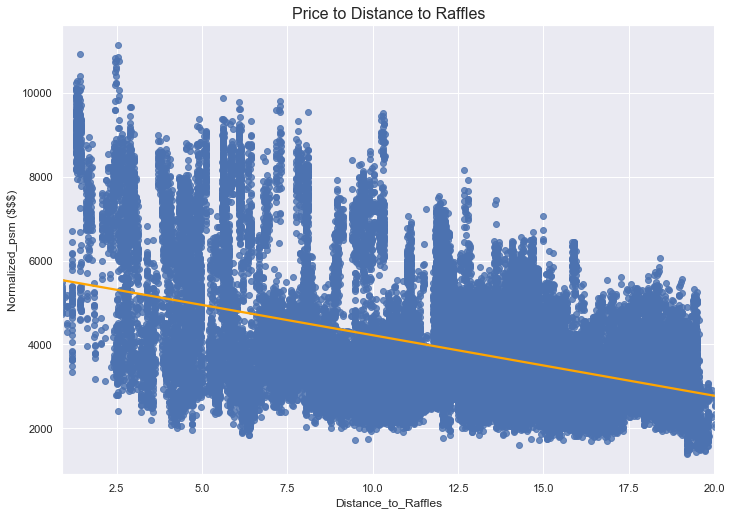

In [112]:
cdf = df_combined[['town','normalized_psm', 'Distance_to_MRT', 'Distance_to_mall', 'Distance_to_Raffles', 'storey_range']]
x = cdf['Distance_to_Raffles']
y = cdf['normalized_psm']
fig = sns.regplot(x=x,y=y, data= cdf, line_kws={'color':'orange'}, ci=None)
fig.set(xlabel='Distance_to_Raffles', ylabel='Normalized_psm ($$$)')
fig.set_title('Price to Distance to Raffles', fontsize=16)
plt.show()

# Performing Multi-Linear Regression on the Data to discover the multiple factors affecting resale price

In [113]:
cdf = df_combined[['town','normalized_psm', 'Distance_to_MRT', 'Distance_to_mall', 'Distance_to_Raffles', 'storey_range']]

In [114]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
model = linear_model.LinearRegression()

#X = np.asanyarray(cdf[['Distance_to_MRT', 'Distance_to_mall', 'Distance_to_Raffles','storey_range']])
X = np.asanyarray(cdf[['Distance_to_MRT', 'Distance_to_mall', 'Distance_to_Raffles','storey_range']])
y = np.asanyarray(cdf[['normalized_psm']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model.fit(X_train, y_train)
print(model.coef_)

# Results
#y_hat = model.predict(X_test)
score = model.score(X_train, y_train)
y_hat = model.predict(X_test)
print('The score of the Multi Linear Regression is: ', score)

[[-475.6517878  -604.72808956 -124.30204377   93.39933718]]
The score of the Multi Linear Regression is:  0.44133758818626667


/Users/bryangwan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:503: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


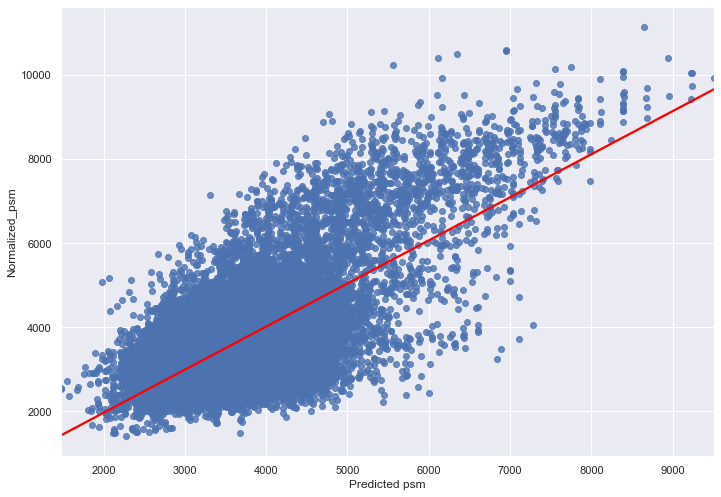

In [115]:
# Visualising the output of the Linear Regression -- y_test against y_hat
fig = sns.regplot(x=y_hat,y=y_test, data= cdf, line_kws={'color':'red'},order=1, ci=None)
fig.set(xlabel='Predicted psm', ylabel='Normalized_psm')
plt.show()

### Linear Regression Coefficients by Town

In [116]:
towns = list(df_combined['town'].unique())

#Creating the headers for the dataframe from cdf
df_coef = pd.DataFrame()
for value in (cdf.columns):
    df_coef[value] = ''

df_coef['town'] = towns #inserting all the town names in the first column'
df_coef.drop('normalized_psm', axis=1, inplace=True)
df_coef['R2-score'] = ''

index=0
for town in towns:
    town_cdf = cdf[cdf['town'] == town]
    X = np.asanyarray(town_cdf[['Distance_to_MRT', 'Distance_to_mall', 'Distance_to_Raffles','storey_range']])
    y = np.asanyarray(town_cdf[['normalized_psm']])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    model.fit(X_train, y_train)
    values = model.coef_
    
    score = model.score(X_train, y_train)

    for town_values in values: 
        df_coef.loc[index,'Distance_to_MRT'] = town_values[0]
        df_coef.loc[index,'Distance_to_mall'] = town_values[1]
        df_coef.loc[index,'Distance_to_Raffles'] = town_values[2]
        df_coef.loc[index,'storey_range'] = town_values[3]
        df_coef.loc[index, 'R2-score'] = score
        index+=1
df_coef

,town,Distance_to_MRT,Distance_to_mall,Distance_to_Raffles,storey_range,R2-score
0,ANG MO KIO,-756.561,-420.227,-219.259,131.615,0.421676
1,BEDOK,-322.981,-460.721,-51.7056,43.648,0.0650877
2,BISHAN,-837.953,89.549,228.061,93.9687,0.424385
3,BUKIT BATOK,-629.862,339.354,-221.017,71.6023,0.253493
4,BUKIT MERAH,-1676.46,-1757.79,-288.661,93.0332,0.564985
5,BUKIT PANJANG,-215.529,276.643,683.417,46.6422,0.445204
6,BUKIT TIMAH,209.411,-403.104,100.769,15.285,0.696382
7,CENTRAL AREA,4625.65,6828.59,-1222.05,74.262,0.594899
8,CHOA CHU KANG,-62.6305,-66.6249,271.076,25.6671,0.135128
9,CLEMENTI,-1812.3,-22.4557,-961,130.365,0.540208


# Multi-variable Polynomial Regression

In [117]:
from sklearn.preprocessing import PolynomialFeatures

cdf = df_combined[['town', 'normalized_psm', 'Distance_to_MRT', 'Distance_to_mall', 'Distance_to_Raffles','storey_range']]

X = np.asanyarray(cdf[['Distance_to_MRT', 'Distance_to_mall', 'Distance_to_Raffles', 'storey_range']])
y = np.asanyarray(cdf[['normalized_psm']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_train_poly

#Scaling the Polynomial to Linear

poly_regr = linear_model.LinearRegression()
Y_train_lin = poly_regr.fit(X_train_poly, y_train)


In [118]:
max_deg = 10
results = dict({})
for deg in range(1, max_deg+1):

    poly = PolynomialFeatures(degree=deg)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    #Scaling the Polynomial to Linear
    model = linear_model.LinearRegression()
    model.fit(X_train_poly, y_train)
    
    y_hat = model.predict(X_test_poly)
    score = model.score(X_train_poly, y_train)
    results[deg] = score
print(results)

{1: 0.44133758818626667, 2: 0.5016318390035892, 3: 0.5245855428943497, 4: 0.5401808726457082, 5: 0.5551220445458085, 6: 0.5714947592124042, 7: 0.5889562616826753, 8: 0.6069825365655867, 9: 0.6067545310426121, 10: 0.5996467669262844}


In [119]:
from sklearn.preprocessing import PolynomialFeatures

cdf = df_combined[['town', 'normalized_psm', 'Distance_to_MRT', 'Distance_to_mall', 'Distance_to_Raffles','storey_range']]

X = np.asanyarray(cdf[['Distance_to_MRT', 'Distance_to_mall', 'Distance_to_Raffles', 'storey_range']])
y = np.asanyarray(cdf[['normalized_psm']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

poly = PolynomialFeatures(degree=8)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

#Scaling the Polynomial to Linear

model = linear_model.LinearRegression()
model.fit(X_train_poly, y_train)
score = model.score(X_train_poly, y_train)
print('Score of Polynomial Regression of degree 8 = ', score)

Score of Polynomial Regression of degree 10 =  0.6069825365655867


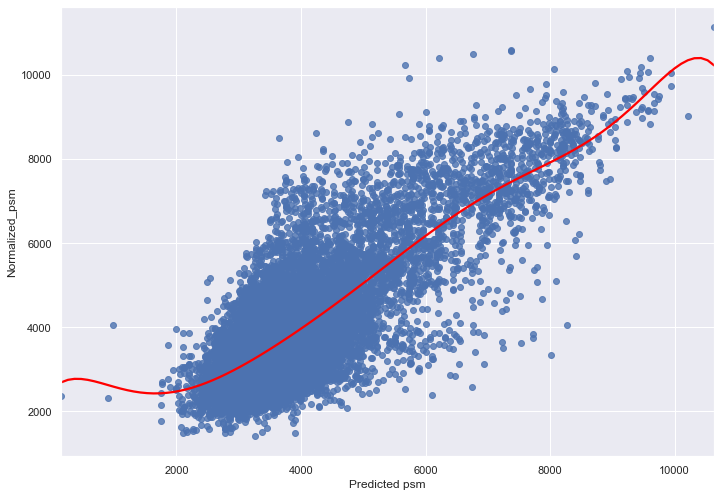

In [120]:
# Visualising the top degree - 8
y_hat = model.predict(X_test_poly) #predicted price values based on test sample

fig = sns.regplot(x=y_hat,y=y_test, data= cdf, line_kws={'color':'red'},order=8, ci=None)
fig.set(xlabel='Predicted psm', ylabel='Normalized_psm')
plt.show()

In [121]:
# removing the outliers from the predicted psm
# Need to remove from X and Y columns. So I will create a dataframe first since the 2 columns are
# independant 

df = pd.DataFrame()
df['y_test'] = y_test.flatten()
df['y_hat'] =y_hat.flatten()


drop_index = list(df[df['y_hat'] < 0].index)
#drop_ind = [str(index) for index in drop_index]
print(drop_index)

for i in range(len(drop_index)):
    df.drop(drop_index[i], inplace=True)

[]


In [122]:
import numpy
# Re running the model to find for optimal poly degree
# No training will be conducted as we are already manipulating with predicted and normalized_psm test data from before
# X = plot_y_hat
# y_test = y_test

X = np.reshape(np.array(df['y_hat'].values.tolist()), (-1,1))
y_test = np.reshape(np.array(df["y_test"].values.tolist()), (-1,1))

max_deg = 10
results = dict({})
for deg in range(1, max_deg+1):

    poly = PolynomialFeatures(degree=deg)
    X_poly = poly.fit_transform(X)
    
    #Scaling the Polynomial to Linear
    model = linear_model.LinearRegression()
    model.fit(X_poly, y_test)
    
    score = model.score(X_poly, y_test)
    results[deg] = score

print(results)
top_r2_degree = max(results, key=results.get)
print('Score of Polynomial Regression of degree {val} = '.format(val=top_r2_degree),results[top_r2_degree])

{1: 0.6056690306777579, 2: 0.6058208083831886, 3: 0.6074482256404764, 4: 0.607945402137934, 5: 0.6080127160264281, 6: 0.6080033297323253, 7: 0.6079734546702413, 8: 0.6069374720354677, 9: 0.6024510172853847, 10: 0.5915050182227146}
Score of Polynomial Regression of degree 5 =  0.6080127160264281


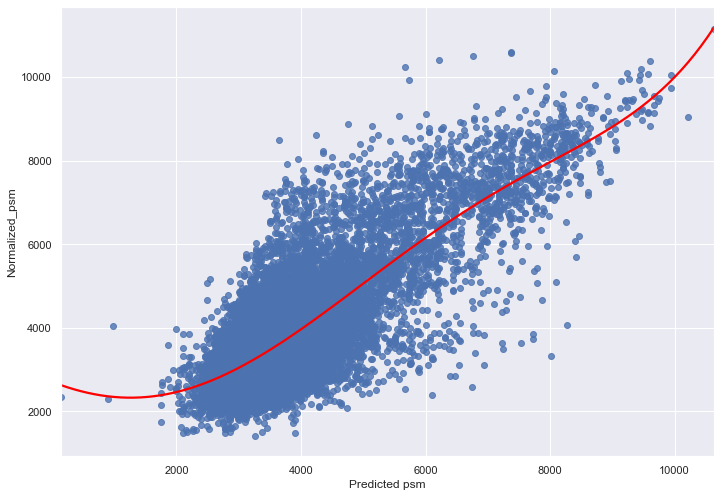

In [124]:
# Visualising the top degree - 5
fig = sns.regplot(x=X,y=y_test, data= cdf, line_kws={'color':'red'},order=5, ci=None)
fig.set(xlabel='Predicted psm', ylabel='Normalized_psm')
plt.show()

## Running Polynomial Regression on each proximity Factor with degree = 10
Investigate further looking at each proxmity factor

In [ ]:
from sklearn.metrics import r2_score
cdf = df_combined[['town', 'normalized_psm', 'Distance_to_MRT', 'Distance_to_mall', 'Distance_to_Raffles','storey_range']]
x_columns = ['Distance_to_MRT', 'Distance_to_mall', 'Distance_to_Raffles', 'storey_range']

results = dict({})
for factor in x_columns:
    X = np.asanyarray(cdf[[factor]])
    y = np.asanyarray(cdf[['normalized_psm']])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    poly = PolynomialFeatures(degree=10)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    #Scaling the Polynomial to Linear

    model = linear_model.LinearRegression()
    model.fit(X_train_poly, y_train)
    
    y_hat = model.predict(X_test_poly)

    results[factor]=model.score(X_train_poly, y_train)
print(results)


In [ ]:
town_r2 = pd.DataFrame()
town_r2['town'] = towns
for town in towns:
    town_cdf = cdf[cdf['town'] == town]
    X = np.asanyarray(town_cdf[['Distance_to_MRT', 'Distance_to_mall', 'Distance_to_Raffles', 'storey_range']])
    y = np.asanyarray(town_cdf[['normalized_psm']])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    poly = PolynomialFeatures(degree=10)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    #Scaling the Polynomial to Linear
    model = linear_model.LinearRegression()
    model.fit(X_train_poly, y_train)
    
    y_hat = model.predict(X_test_poly)
    score = model.score(X_train_poly, y_train)
    town_r2[town] = score
print(town_r2)

# Map Visualization

In [ ]:
df_address = pd.read_csv('df_sample_geocodes.csv')
df_mrt_geocodes = pd.read_csv('mrt_stations_geocodes.csv')
df_mall_geocodes = pd.read_csv('Shopping-Malls.csv')
df_address_test = df_address.iloc[:300, :]
df_address_test

In [ ]:
from geopy.geocoders import Nominatim
import folium

geolocator = Nominatim(user_agent="sg_price")
sg_loc = geolocator.geocode('Singapore')
map_sg = folium.Map(location=[sg_loc.latitude, sg_loc.longitude], zoom_start =12)

#Markers for each mrt
for lat, lng, location in zip(df_mrt_geocodes['Latitude'], df_mrt_geocodes['Longitudes'], df_mrt_geocodes['Location']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        icon=folium.Icon(icon='cloud'),
        parse_html=False).add_to(map_sg)

#Markers for malls
for lat, lng, mall in zip(df_mall_geocodes['Latitude'], df_mall_geocodes['Longitude'],df_mall_geocodes['Malls']):
    label = '{}'.format(mall)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)

#Markers for each mrt
for lat, lng, address in zip(df_address_test['Latitudes'], df_address_test['Longitudes'], df_address_test['Address']):
    label = '{}'.format(address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)
map_sg